In [ ]:
from models import CNN
import torch.nn as nn

config = {'algorithm': 'fedprox',
          'baseline': False,
          'batch_size': 50,
          'criterion': nn.CrossEntropyLoss,
          'data_path': './data',
          'device': 'cpu',
          'ds_name': 'organcmnist',
          'eval_train': True,
          'gamma': None,
          'global_epochs': 4,
          'iid': False,
          'learning_rate': 0.01,
          'local_epochs': 3,
          'log_path': './logs',
          'model': CNN,
          'n_channels': 1,
          'n_classes': 11,
          'num_clients': 2,
          'participation_percent': 1.0,
          'seed': 1,
          'task': 'multi-class',
          'test_transform': None,
          'train_transform': None,
          'mu': 0.1
          }


What do we want to have,
* I case of no cross validation:
    * We have clients, each client have a dataframe of loss (mean loss) and accuracy per communication round.
    * We have a server with test accuracy for each communication round.
We want to plot:
* Mean accuracy across clients (per communication round)
* Accuracy for the server (per communication round)
* Mean loss across clients (per communication round)
---
* In case of cross validation:
    * Display overlay acccuracy plots across all folds (Server, client if you want)
    * Display overlay loss plots across all folds (mean loss)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.1541283677021662, 0.1493307550748189, 0.1526366720596949, 0.15045960247516624, 0.15102402865886688]
(5,)


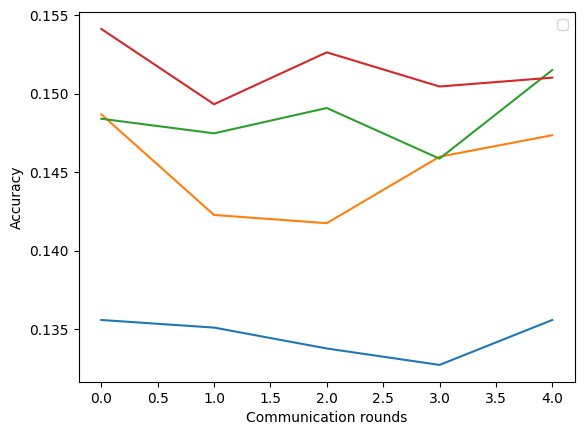

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

def plots_cv(CV_log_path, plot_clients=False):
    main_folder = CV_log_path
    folds = [os.path.join(main_folder , i) if os.path.isdir(os.path.join(main_folder, i)) and i.startswith("fold") else None for i in os.listdir(main_folder)]
    folds_clients = {}
    for i, fold_folder in enumerate(folds):
        clients_dfs = {}
        for file in os.listdir(fold_folder):
            if file.endswith(".csv"):
                clients_dfs[file[:-4]] = pd.read_csv(os.path.join(fold_folder, file), index_col=0)
        folds_clients[fold_folder] = clients_dfs
    num_rounds = len(clients_dfs[file[:-4]])
    loss = []
    n = 0
    for round in range(1, num_rounds+1):
        acc = []
        for fold in range(1, len(folds_clients)+1):
            ffold = folds_clients[os.path.join(main_folder, f"fold_{fold}")]
            temp_acc = []
            temp_loss = []
            for client in ffold:
                temp_acc.append(ffold[client].at[round, "Accuracy"])
                temp_loss.append(ffold[client].at[round, "Loss"])
            temp_acc= np.mean(temp_acc)
            acc.append(temp_acc)
        plt.plot(acc)    
    print(acc)
    print(np.array(acc).shape)
    plt.ylabel("Accuracy")
    plt.xlabel("Communication rounds")
    plt.legend()
    # plt.xlabel("Communications")
    return folds_clients

folds_clients = plots_cv("./logs/CrossValidation/")

In [18]:
fold = folds_clients['./logs/CrossValidation/fold_1']
fold["Client_0"]

,Accuracy,Loss
1,0.133769,1.249377
2,0.149008,0.557653
3,0.144896,0.421272
4,0.153362,0.347603


In [ ]:
import numpy as np
def plots_no_cv(log_path, ds_name, plot_clients=False):
    log_folder = os.path.join(log_path, f"log_{ds_name}")
    print(log_folder)
    clients_dataframes = []
    dataframe = {"Mean_loss": [], "Mean Accuracy": []}
    for file in os.listdir(log_folder):
        if file.endswith(".csv"):
            clients_dataframes.append(pd.read_csv(os.path.join(log_folder, file)).drop(columns=["Unnamed: 0"]))
    if plot_clients:
        for client_idx, client_dataframe in enumerate(clients_dataframes):
            acc = client_dataframe["Accuracy"]
            loss = client_dataframe["Loss"]
            plt.plot([i+1 for i in client_dataframe.index], acc, label=f"Client {client_idx+1} Accuracy")
            plt.xlabel("Communication round")
            plt.ylabel("Accuracy")
            plt.title(f"Client {client_idx+1} Accuracy")
            plt.legend()
            plt.show()
            plt.plot([i+1 for i in client_dataframe.index], acc, label=f"Client {client_idx+1} loss")
            plt.xlabel("Communication round")
            plt.legend()
            plt.ylabel("Loss")
            plt.title(f"Client {client_idx+1} Loss")
            plt.show()
        print("joint")
        for client_idx, client_dataframe in enumerate(clients_dataframes):
            plt.plot([i for i in range(1, len(client_dataframe)+1)], client_dataframe["Loss"], label=f"Client {client_idx} loss")
        plt.legend()
        plt.show
        plt.clf()
        for client_idx, client_dataframe in enumerate(clients_dataframes):
            plt.plot([i for i in range(1, len(client_dataframe)+1)], client_dataframe["Accuracy"], label=f"Client {client_idx} accuracy")
        plt.legend()
        plt.show

    for comm_round in clients_dataframes[0].index:
        loss = 0
        acc = 0
        for client_df in clients_dataframes:
            loss += client_df.at[comm_round, "Loss"]
            acc += client_df.at[comm_round, "Accuracy"]
        dataframe["Mean_loss"].append(loss / len(clients_dataframes))
        dataframe["Mean Accuracy"].append(acc / len(clients_dataframes))
    df = pd.DataFrame(dataframe)
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    axs[0].plot([i+1 for i in df.index], df["Mean Accuracy"], label='Accuracy')
    axs[1].plot([i+1 for i in df.index], df["Mean_loss"], label='Loss')
    # Set axis labels and legend
    axs[1].set_xlabel('communication round')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title("Average accuracy of clients per communication round")
    axs[1].set_ylabel('Loss')
    axs[1].set_title("Average loss of clients per communication round")
    axs[0].legend()
    axs[1].legend()
    plt.show()

plots_no_cv(log_path="logs",ds_name=config["ds_name"], plot_clients=True)

In [ ]:
# Create the DataFrame
data = {'Accuracy': [0.133769, 0.149008, 0.144896, 0.153362], 'Loss': [1.249377, 0.557653, 0.421272, 0.347603]}
df = pd.DataFrame(data)
len(df)

In [12]:
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
DataClass=getattr(medmnist, INFO["bloodmnist"]["python_class"])(root="./data", split="val",transform=transforms.ToTensor())
im1 = DataClass[0][0]
print(im1.shape)
# plt.imshow(im1.permute(1,2,0))
import torchvision.utils as vutils
vutils.save_image(im1, '../tensor_image.png')

torch.Size([3, 28, 28])


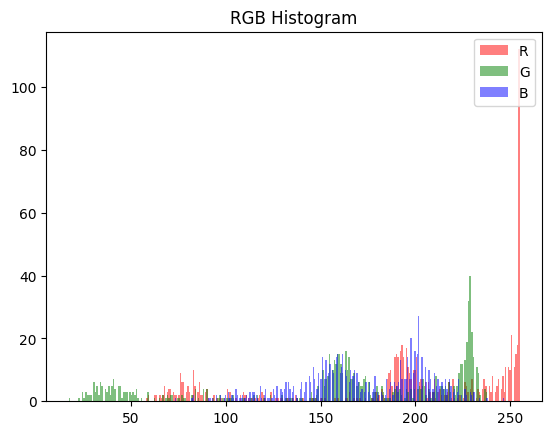

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
img = Image.open('../tensor_image.png')

# Convert the image to a numpy array
img_array = np.array(img)

# Split the image into R, G, B channels
r = img_array[:, :, 0].ravel()
g = img_array[:, :, 1].ravel()
b = img_array[:, :, 2].ravel()

t = r+g+b
# plt.hist(t, bins=256, alpha=1, color='black', label='all')
# Plot the histograms of each channel on the same graph
plt.hist(r, bins=256, alpha=0.5, color='red', label='R')
plt.hist(g, bins=256, alpha=0.5, color='green', label='G')
plt.hist(b, bins=256, alpha=0.5, color='blue', label='B')

# Set the title and legend of the graph
plt.title('RGB Histogram')
plt.legend(loc='upper right')

# Show the graph
plt.show()
